In [1]:
# We Will try to understand more of the activation functions, Gradients and Batch norm.
# We will be using most of the code from makemore_mlp but make it more generalized.

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read in all teh words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
#build dataset
block_size = 3 # context length : how any characters do we take to predict the next one?

def build_dataset(words):
    X,Y = [] , []
    for w in words :
        context = [0] * block_size
        for ch in w + '.' :
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = (int)(0.8*len(words))
n2 = (int)(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])   # 80% to training
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% to validation
Xtest, Ytest = build_dataset(words[n2:]) # 10% to test

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [11]:
# MLP 

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neuroons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size , n_embd) ,             generator = g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator = g)
b1 = torch.randn(n_hidden,                          generator = g)
W2 = torch.randn((n_hidden, vocab_size),            generator = g)
b2 = torch.randn(vocab_size,                        generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set the require_gradient values to True
for p in parameters: 
    p.requires_grad = True

11897


In [12]:
# build the MLP

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre_activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    #back ward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000 : 25.5262
  10000/ 200000 : 1.8338
  20000/ 200000 : 2.2061
  30000/ 200000 : 2.3821
  40000/ 200000 : 2.7116
  50000/ 200000 : 2.1010
  60000/ 200000 : 2.7503
  70000/ 200000 : 2.3828
  80000/ 200000 : 1.9547
  90000/ 200000 : 2.5844
 100000/ 200000 : 2.3852
 110000/ 200000 : 2.1428
 120000/ 200000 : 2.0558
 130000/ 200000 : 1.7803
 140000/ 200000 : 2.4744
 150000/ 200000 : 2.2478
 160000/ 200000 : 1.9481
 170000/ 200000 : 2.1123
 180000/ 200000 : 2.5137
 190000/ 200000 : 1.7595


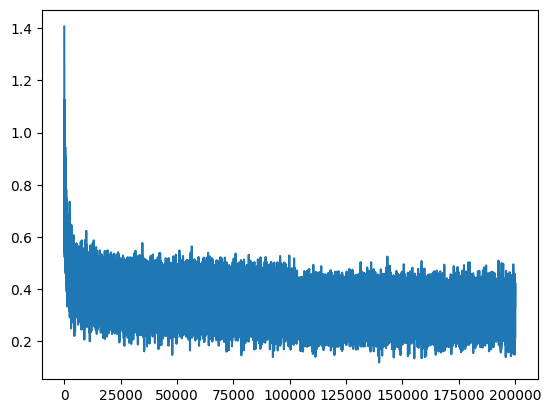

In [13]:
plt.plot(lossi)

In [14]:
# evaluate the loss of datasets that we pass
@torch.no_grad() #this decorator disables gradient tracking

def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr), 
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0] , -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits , y)
    print( split, loss.item())

split_loss('train')
split_loss('val')

train 2.1231679916381836
val 2.1867377758026123


In [15]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        #forward pass the neural net
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        #sample from the distributions
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special '.' token then break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decode and print the generated names

carmah.
amelle.
khy.
mili.
taty.
skandell.
mahnen.
den.
rhy.
kaeli.
nellara.
chaiivia.
leigh.
ham.
joce.
quinn.
suli.
wan.
adbi.
wanthoniel.


In [16]:
# for the first run out of 200000 runs we did during training . We can see the loss is almost 25 => the initializations are not good
# so if we see in the loss calculation the logits are impacting a lot
# so if we can keeo the logits normalized in the initial run we will see better loss
# for logits to be closer to 0 we need to change W2 and b2 values

# reinitializing the parameters

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neuroons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size , n_embd) ,             generator = g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator = g)
b1 = torch.randn(n_hidden,                          generator = g)
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01 # its always safer to keep the weights closer to 0 than initializing them to 0
b2 = torch.randn(vocab_size,                        generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set the require_gradient values to True
for p in parameters: 
    p.requires_grad = True


11897


In [17]:
# lets rerun the neural network

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre_activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    #back ward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000 : 3.2999
  10000/ 200000 : 1.7637
  20000/ 200000 : 2.0670
  30000/ 200000 : 2.2983
  40000/ 200000 : 2.5069
  50000/ 200000 : 1.9090
  60000/ 200000 : 2.5140
  70000/ 200000 : 2.1410
  80000/ 200000 : 1.8219
  90000/ 200000 : 2.1900
 100000/ 200000 : 2.1304
 110000/ 200000 : 2.0749
 120000/ 200000 : 1.9313
 130000/ 200000 : 1.7900
 140000/ 200000 : 2.2766
 150000/ 200000 : 2.1514
 160000/ 200000 : 1.8179
 170000/ 200000 : 2.0655
 180000/ 200000 : 2.4314
 190000/ 200000 : 1.7584


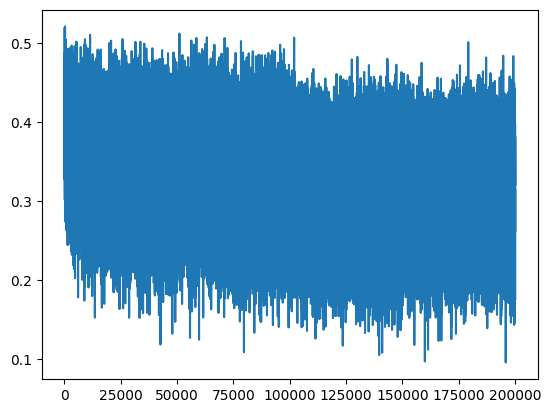

In [19]:
# we see the initial loss now is descent
plt.plot(lossi)

In [20]:
# evaluate the loss of datasets that we pass
@torch.no_grad() #this decorator disables gradient tracking

def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr), 
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0] , -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits , y)
    print( split, loss.item())

split_loss('train')
split_loss('val')

train 2.0663647651672363
val 2.149362802505493


(array([2184.,  137.,  105.,   68.,   46.,   36.,   42.,   44.,   41.,
          46.,   23.,   25.,   16.,   22.,   13.,   30.,   25.,   14.,
          16.,   18.,   15.,   16.,   25.,   24.,   12.,   17.,   26.,
          20.,   17.,   14.,   17.,   17.,   27.,   16.,   31.,   14.,
          23.,   24.,   24.,   15.,   35.,   38.,   30.,   38.,   48.,
          47.,   61.,   82.,  125., 2551.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

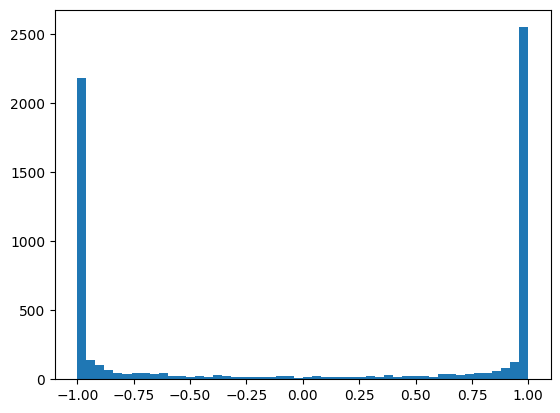

In [21]:
# going deeper into the initializations and analyze the h
# lets try to plot the h in histogram and see how tanh is performing

plt.hist(h.view(-1).tolist(), 50)

In [22]:
# Now if we see the above histogram , a lot of results are at the extremes -1 and 1.
# and the way gradient for tanh is calculated is (1-t**2) * out.grad. And if t is either +1 or -1 we see that the gradient 
# gets cancelled out and gives 0 => neuron is a dead neuron and ont be helping  in the backward pass => no learning
# so we need to make sure that the neuron doesnot always have extreme values.
# so we make sure the inputs to tanh are descent

# reinitializing the parameters

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neuroons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size , n_embd) ,             generator = g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator = g) * 0.1
b1 = torch.randn(n_hidden,                          generator = g) * 0.01 # just to show little bit variation 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01 # its always safer to keep the weights closer to 0 than initializing them to 0
b2 = torch.randn(vocab_size,                        generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set the require_gradient values to True
for p in parameters: 
    p.requires_grad = True

11897


In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre_activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    #back ward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000 : 3.2954
  10000/ 200000 : 1.7715
  20000/ 200000 : 1.9675
  30000/ 200000 : 2.3570
  40000/ 200000 : 2.4918
  50000/ 200000 : 1.7818
  60000/ 200000 : 2.3094
  70000/ 200000 : 2.0401
  80000/ 200000 : 1.6410
  90000/ 200000 : 2.2646
 100000/ 200000 : 2.0744
 110000/ 200000 : 2.1641
 120000/ 200000 : 1.9945
 130000/ 200000 : 1.7839
 140000/ 200000 : 2.1801
 150000/ 200000 : 2.2105
 160000/ 200000 : 1.8620
 170000/ 200000 : 2.0833
 180000/ 200000 : 2.5429
 190000/ 200000 : 1.7609


(array([853., 173., 103.,  64.,  68.,  67.,  45.,  39.,  45.,  46.,  43.,
         49.,  47.,  46.,  37.,  34.,  44.,  54.,  53.,  52.,  93.,  83.,
        130., 271., 517., 532., 288., 146., 107.,  76.,  67.,  71.,  57.,
         43.,  65.,  56.,  43.,  38.,  47.,  41.,  47.,  57.,  52.,  51.,
         67.,  69.,  95., 113., 185., 931.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

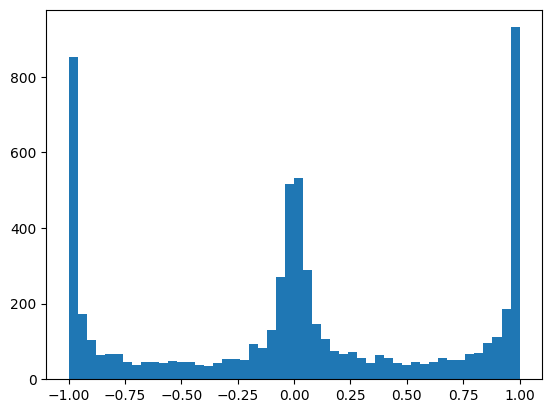

In [24]:
# lets see the distribution of tanh values
plt.hist(h.view(-1).tolist(), 50)

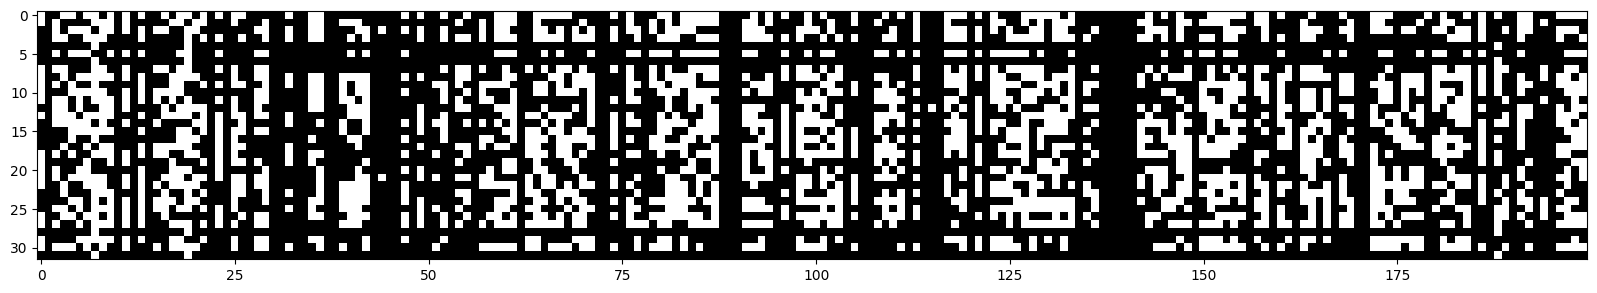

In [25]:
# lets try to plot the h values . if the values are at extreme then we get the white color or else black
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.9, cmap = 'gray', interpolation = 'nearest')

In [26]:
# evaluate the loss of datasets that we pass
@torch.no_grad() #this decorator disables gradient tracking

def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr), 
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0] , -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits , y)
    print( split, loss.item())

split_loss('train')
split_loss('val')

train 2.0593159198760986
val 2.125847578048706


In [27]:
# we got better results after proper initializations

# kaiming Initialization

In [30]:
# For now we have multiplied the weights and biases with some random numbers.
# but there are ways to generate the appropriate numbers
# The best way to initialize the weights so the weights standarddeviation is closer to 1 is by diving the weights with square root of number of inputs
# Based on the keiming paper on proper initiliazations we can achive this by multiplying the weights with std
# std = gain/(fan_in ** 0.5)  . Gain have assigned values based on the activation function we are using
# fan _ in is the number of inputs to the neuron.
# for tanh th egain value is 5/3

In [31]:
# initializing the parameters
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neuroons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size , n_embd) ,             generator = g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator = g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                          generator = g) * 0.01 # just to show little bit variation 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01 # its always safer to keep the weights closer to 0 than initializing them to 0
b2 = torch.randn(vocab_size,                        generator = g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set the require_gradient values to True
for p in parameters: 
    p.requires_grad = True

11897


In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre_activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    #back ward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000 : 3.2963
  10000/ 200000 : 1.6929
  20000/ 200000 : 1.8320
  30000/ 200000 : 2.3207
  40000/ 200000 : 2.4915
  50000/ 200000 : 1.7569
  60000/ 200000 : 2.4385
  70000/ 200000 : 2.1219
  80000/ 200000 : 1.6795
  90000/ 200000 : 2.1480
 100000/ 200000 : 2.1768
 110000/ 200000 : 2.0357
 120000/ 200000 : 1.7839
 130000/ 200000 : 1.7549
 140000/ 200000 : 2.1074
 150000/ 200000 : 2.1052
 160000/ 200000 : 1.7375
 170000/ 200000 : 2.0859
 180000/ 200000 : 2.5050
 190000/ 200000 : 1.7592


In [33]:
@torch.no_grad() #this decorator disables gradient tracking

def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr), 
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0] , -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits , y)
    print( split, loss.item())

split_loss('train')
split_loss('val')

train 2.035102367401123
val 2.1148674488067627


In [34]:
# this initialization is also not important now a days. Batch normalization avoids the need of precise initialization of weights 

# Batch Normalization

In [36]:
# we were multiplying the weights with magic numbers so the initial values are standardized 
# With batch normalization , instead of multiplying the values, we normalize the values so the standarad deviation is 1

# One importand thing is we only want the initial values to be roughly standardized, We dont want to force standardization at every run, but we 
# want neurins to learn through the backpropagation and normalize and shift the values

In [42]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neuroons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size , n_embd) ,             generator = g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator = g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                          generator = g) * 0.01 # just to show little bit variation 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01 # its always safer to keep the weights closer to 0 than initializing them to 0
b2 = torch.randn(vocab_size,                        generator = g) * 0

bngain = torch.ones((1, n_hidden)) # batch normalization initial gain
bnbias = torch.zeros((1, n_hidden)) # batch normalization initial bias

# bngain and bnbias will allow neural network to learn through backpropogation and then shift values to maintain the standarddeviation to 1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set the require_gradient values to True
for p in parameters: 
    p.requires_grad = True

12297


In [43]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre_activation

    # batch normalization
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdims = True))/hpreact.std(0,keepdim = True) + bnbias
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    #back ward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000 : 3.3054
  10000/ 200000 : 1.7978
  20000/ 200000 : 1.9030
  30000/ 200000 : 2.4623
  40000/ 200000 : 2.4436
  50000/ 200000 : 1.8843
  60000/ 200000 : 2.4164
  70000/ 200000 : 2.1734
  80000/ 200000 : 1.7217
  90000/ 200000 : 2.3225
 100000/ 200000 : 2.2514
 110000/ 200000 : 2.1481
 120000/ 200000 : 1.9692
 130000/ 200000 : 1.7992
 140000/ 200000 : 2.2786
 150000/ 200000 : 2.1926
 160000/ 200000 : 1.9286
 170000/ 200000 : 2.1592
 180000/ 200000 : 2.5601
 190000/ 200000 : 1.7961


In [45]:
@torch.no_grad() #this decorator disables gradient tracking

def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr), 
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest),
    }[split]

    emb = C[x] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre_activation

    # batch normalization
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdims = True))/hpreact.std(0,keepdim = True) + bnbias
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print( split, loss.item())

split_loss('train')
split_loss('val')

train 2.0649521350860596
val 2.1251986026763916


In [46]:
# Batch normalization is actually using the mean and standard deviation od the batch which makes all the samples in the batch kind of interdependent
# which is usually what we expect in the neural network training.
# But also because a sample is depending on the coming samples , this adds jitter in the gradient value calculations, and becuase of this jitter 
# there is no chance that the neural network overfits.

# batch normalization also offers regularization in a way

In [47]:
# One more important thing to notice is because we normalizaing entire batch , the neural network when deployed, will expect 
# batch of inputs. But in reality we only pass in single value and except the result.

# to solve this once the training is done we calculate the one time batch normalization value and use it for inferences

In [50]:
#calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

In [51]:
@torch.no_grad() #this decorator disables gradient tracking

def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr), 
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest),
    }[split]

    emb = C[x] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre_activation

    # batch normalization
    hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print( split, loss.item())

split_loss('train')
split_loss('val')

train 2.0649521350860596
val 2.125127077102661


In [52]:
# Calibrating again the batch mean and batch std after the training again is waste of the resources and time . 
# So trying to calibrate the bnmean and bnstd while training itself will be more advantagious

In [53]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neuroons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size , n_embd) ,             generator = g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator = g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                          generator = g) * 0.01 # just to show little bit variation 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01 # its always safer to keep the weights closer to 0 than initializing them to 0
b2 = torch.randn(vocab_size,                        generator = g) * 0

bngain = torch.ones((1, n_hidden)) # batch normalization initial gain
bnbias = torch.zeros((1, n_hidden)) # batch normalization initial bias
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# bngain and bnbias will allow neural network to learn through backpropogation and then shift values to maintain the standarddeviation to 1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set the require_gradient values to True
for p in parameters: 
    p.requires_grad = True

12297


In [54]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre_activation

    # batch normalization
    bnmeani = hpreact.mean(0, keepdims = True)
    bnstdi = hpreact.std(0,keepdim = True)
    hpreact = bngain * (hpreact - bnmeani)/ bnstdi+ bnbias


    # no gradient calculation for bnmean_running and bnstd_runing
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # will mostly be bnmean_running but will get small update from bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    #back ward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000 : 3.3054
  10000/ 200000 : 1.7978
  20000/ 200000 : 1.9030
  30000/ 200000 : 2.4623
  40000/ 200000 : 2.4436
  50000/ 200000 : 1.8843
  60000/ 200000 : 2.4164
  70000/ 200000 : 2.1734
  80000/ 200000 : 1.7217
  90000/ 200000 : 2.3225
 100000/ 200000 : 2.2514
 110000/ 200000 : 2.1481
 120000/ 200000 : 1.9692
 130000/ 200000 : 1.7992
 140000/ 200000 : 2.2786
 150000/ 200000 : 2.1926
 160000/ 200000 : 1.9286
 170000/ 200000 : 2.1592
 180000/ 200000 : 2.5601
 190000/ 200000 : 1.7961


In [55]:
# using the bnmean_running and bnstd_running instead of explicit calibration of bnmean and bnstd

@torch.no_grad() #this decorator disables gradient tracking

def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr), 
        'val'   : (Xdev, Ydev),
        'test'  : (Xtest, Ytest),
    }[split]

    emb = C[x] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre_activation

    # batch normalization
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print( split, loss.item())

split_loss('train')
split_loss('val')

train 2.0649776458740234
val 2.125718355178833


In [56]:
# Referrence for coding : https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4

In [57]:
# because we are using batch normalization, the addition of bias values to the weights is not useful
# we hpreact = embcat @ W1 + b1, but adding b1 is useless because we in the batch normalization we do the mean of these values and 
# substract the mean from hpreact which cancels the b1
# bnbias will do the work of b1

# lets rewrite the code with all the changes

In [76]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neuroons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size , n_embd) ,             generator = g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator = g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                          generator = g) * 0.01 # just to show little bit variation 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01 # its always safer to keep the weights closer to 0 than initializing them to 0
b2 = torch.randn(vocab_size,                        generator = g) * 0

bngain = torch.ones((1, n_hidden)) # batch normalization initial gain
bnbias = torch.zeros((1, n_hidden)) # batch normalization initial bias
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# bngain and bnbias will allow neural network to learn through backpropogation and then shift values to maintain the standarddeviation to 1

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set the require_gradient values to True
for p in parameters: 
    p.requires_grad = True

12097


In [59]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0] , -1) # concatinate the vectors
   # linear layer
    hpreact = embcat @ W1  #+ b1 # hidden layer pre_activation

    # batch normalization
    bnmeani = hpreact.mean(0, keepdims = True)
    bnstdi = hpreact.std(0,keepdim = True)
    hpreact = bngain * (hpreact - bnmeani)/ bnstdi+ bnbias


    # no gradient calculation for bnmean_running and bnstd_runing
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # will mostly be bnmean_running but will get small update from bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # non linear layer
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    #back ward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    lossi.append(loss.log10().item())

      0/ 200000 : 3.3111
  10000/ 200000 : 2.5342
  20000/ 200000 : 1.9578
  30000/ 200000 : 2.4050
  40000/ 200000 : 2.1535
  50000/ 200000 : 2.1007
  60000/ 200000 : 1.8789
  70000/ 200000 : 1.9506
  80000/ 200000 : 2.4958
  90000/ 200000 : 2.2811
 100000/ 200000 : 2.0015
 110000/ 200000 : 2.0569
 120000/ 200000 : 1.8678
 130000/ 200000 : 2.1272
 140000/ 200000 : 1.5888
 150000/ 200000 : 1.8355
 160000/ 200000 : 2.2442
 170000/ 200000 : 2.3872
 180000/ 200000 : 2.3752
 190000/ 200000 : 2.2005


In [61]:
# lets Structure our code more similar to that of pytorch

In [77]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out) , generator = g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x@ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters ( trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers ( trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True, unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize the unit variance
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the charcater embedded vectors
n_hidden = 100 # the number of neurons in the hidden layer of MLP
g =  torch.Generator().manual_seed(2147483647) # for reproducability

# we are using 6 layer MLP
C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd*block_size , n_hidden), Tanh(),
    Linear(         n_hidden , n_hidden), Tanh(),
    Linear(         n_hidden , n_hidden), Tanh(),
    Linear(         n_hidden , n_hidden), Tanh(),
    Linear(         n_hidden , n_hidden), Tanh(),
    Linear(         n_hidden , vocab_size),
    
]

with torch.no_grad():
    #last layer : make less confident
    layers[-1].weight *= 0.1
    # all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [67]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0] , -1) # concatinate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss functions

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # after debug : would take out retrain_grad
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break

      0/ 200000 : 3.2949


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 20.94%
layer 3 (      Tanh): mean +0.00, std 0.69, saturated: 8.75%
layer 5 (      Tanh): mean +0.01, std 0.68, saturated: 7.47%
layer 7 (      Tanh): mean -0.02, std 0.66, saturated: 5.91%
layer 9 (      Tanh): mean -0.01, std 0.66, saturated: 6.34%


Text(0.5, 1.0, 'activation distribution')

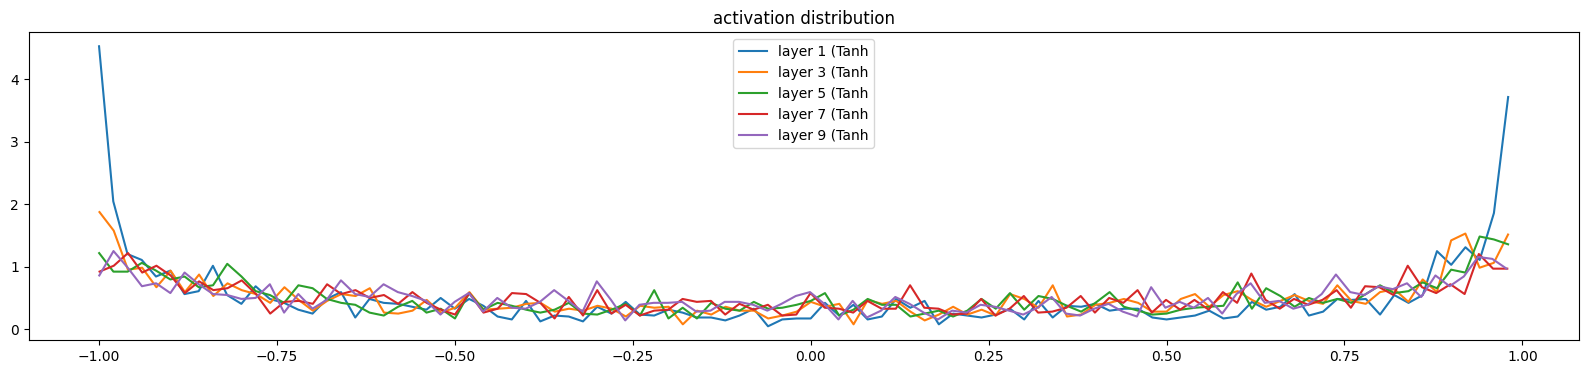

In [70]:
# Visualize histogram to see if the values from tanh are distributed equally between all values b/w -1 & 1
plt.figure(figsize = (20,4)) # width and height of the plot
legends = []
for i , layer in enumerate(layers[:-1]): # note excluse the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'Gradient distribution')

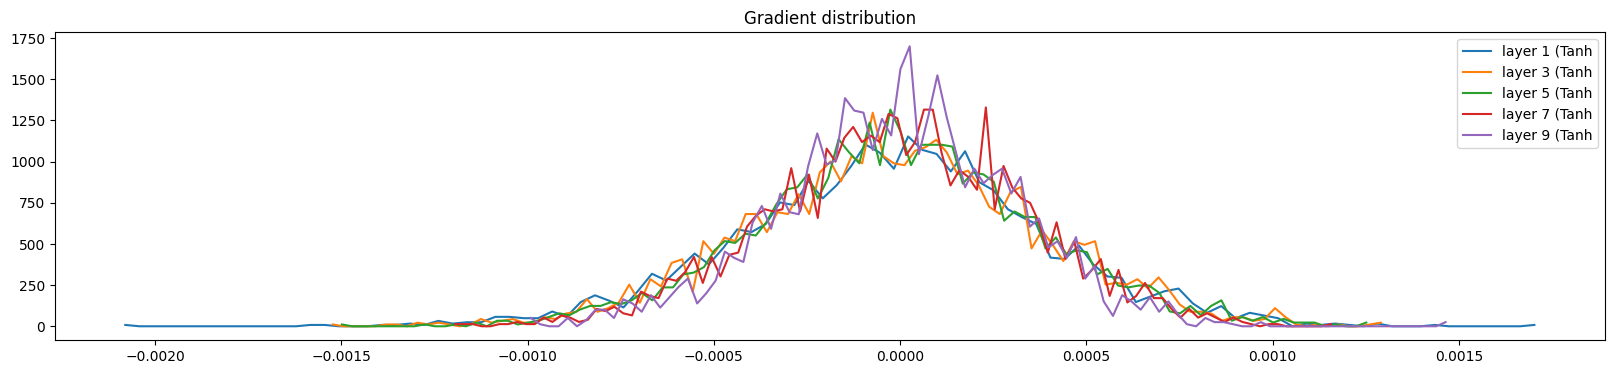

In [72]:
# Lets see if the gradients are nicely distributed 
# Visualize histogram to see if the values from tanh are distributed equally between all values b/w -1 & 1
plt.figure(figsize = (20,4)) # width and height of the plot
legends = []
for i , layer in enumerate(layers[:-1]): # note excluse the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('Gradient distribution')

Weight   (27, 10) | mean +0.000014 | std 1.352992e-03 | grad:data ratio 1.352012e-03
Weight  (30, 100) | mean +0.000013 | std 1.130698e-03 | grad:data ratio 3.625614e-03
Weight (100, 100) | mean -0.000001 | std 1.025412e-03 | grad:data ratio 6.172695e-03
Weight (100, 100) | mean +0.000006 | std 8.943320e-04 | grad:data ratio 5.327085e-03
Weight (100, 100) | mean +0.000004 | std 8.205113e-04 | grad:data ratio 4.907900e-03
Weight (100, 100) | mean +0.000004 | std 7.513820e-04 | grad:data ratio 4.490046e-03
Weight  (100, 27) | mean +0.000000 | std 2.299064e-02 | grad:data ratio 2.265717e+00


Text(0.5, 1.0, 'Weights Gradient distribution')

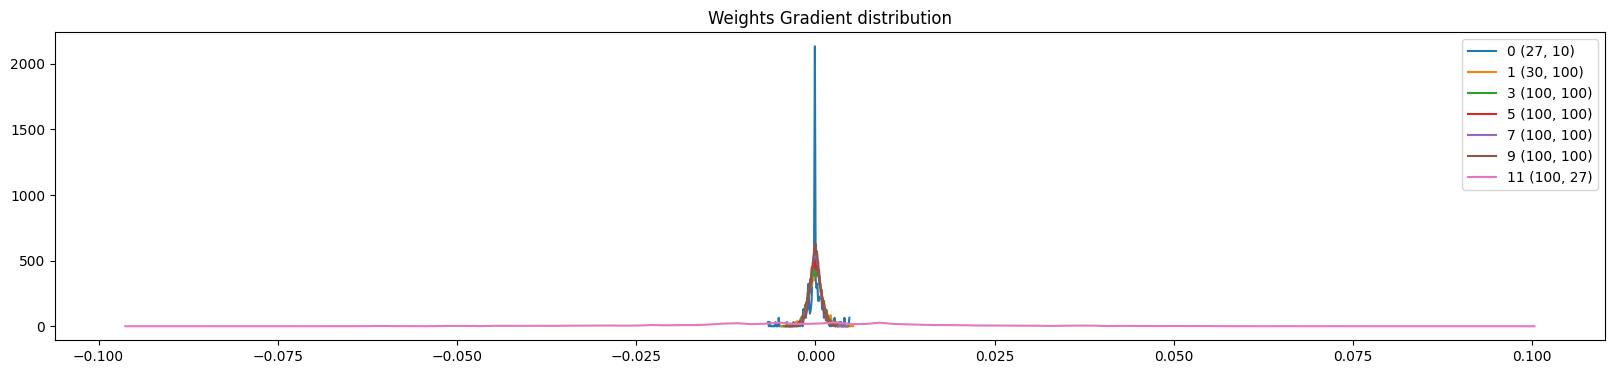

In [75]:
# visualize the weights distribution
plt.figure(figsize = (20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('Weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(),t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weights Gradient distribution')        


In [79]:
# its always important to get the ratio by which the weights are being updated . To keep track of this we add new parameter ud

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0] , -1) # concatinate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss functions

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # after debug : would take out retrain_grad
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    lossi.append(loss.log10().item())
    if i>= 1000:
        break

      0/ 200000 : 3.2949


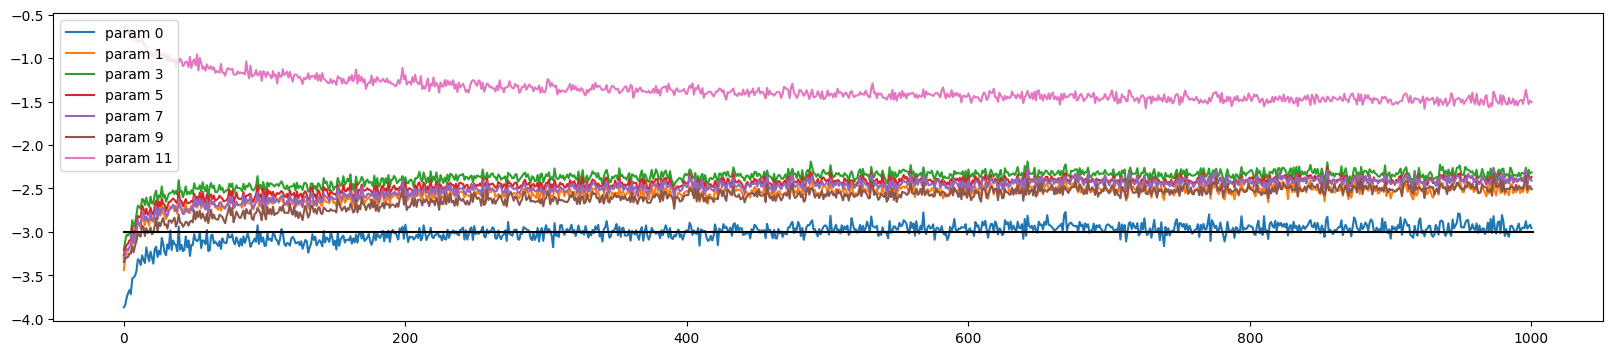

In [84]:
plt.figure(figsize = (20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: # we are looking the updates on weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
        

In [89]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neuroons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size , n_embd) ,             generator = g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator = g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                          generator = g) * 0.01 # just to show little bit variation 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01 # its always safer to keep the weights closer to 0 than initializing them to 0
b2 = torch.randn(vocab_size,                        generator = g) * 0

bngain = torch.ones((1, n_hidden)) # batch normalization initial gain
bnbias = torch.zeros((1, n_hidden)) # batch normalization initial bias
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# bngain and bnbias will allow neural network to learn through backpropogation and then shift values to maintain the standarddeviation to 1

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set the require_gradient values to True
for p in parameters: 
    p.requires_grad = True

12097


In [92]:
# Everything looks fine Now lets introduce Batch normalization
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out) , generator = g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x@ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters ( trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers ( trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True, unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize the unit variance
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the charcater embedded vectors
n_hidden = 100 # the number of neurons in the hidden layer of MLP
g =  torch.Generator().manual_seed(2147483647) # for reproducability

# we are using 6 layer MLP
C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd*block_size , n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden , n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , vocab_size), BatchNorm1d(vocab_size),
    
]

with torch.no_grad():
    #last layer : make less confident
   # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [93]:
# its always important to get the ratio by which the weights are being updated . To keep track of this we add new parameter ud

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0] , -1) # concatinate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss functions

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # after debug : would take out retrain_grad
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    lossi.append(loss.log10().item())


      0/ 200000 : 3.3136


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.19%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.12%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.66%


Text(0.5, 1.0, 'activation distribution')

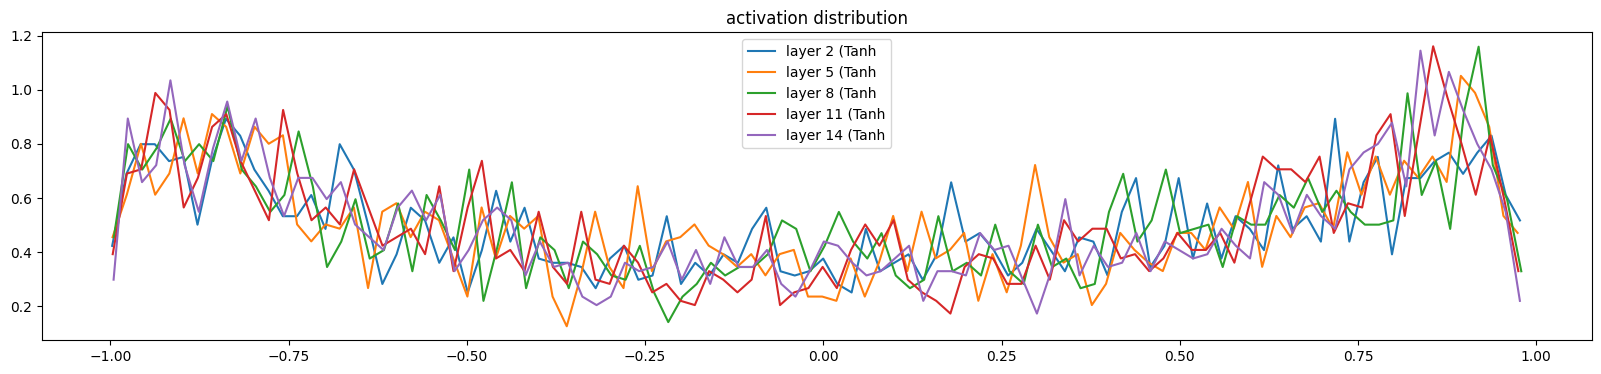

In [94]:
# Visualize histogram to see if the values from tanh are distributed equally between all values b/w -1 & 1
plt.figure(figsize = (20,4)) # width and height of the plot
legends = []
for i , layer in enumerate(layers[:-1]): # note excluse the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'Gradient distribution')

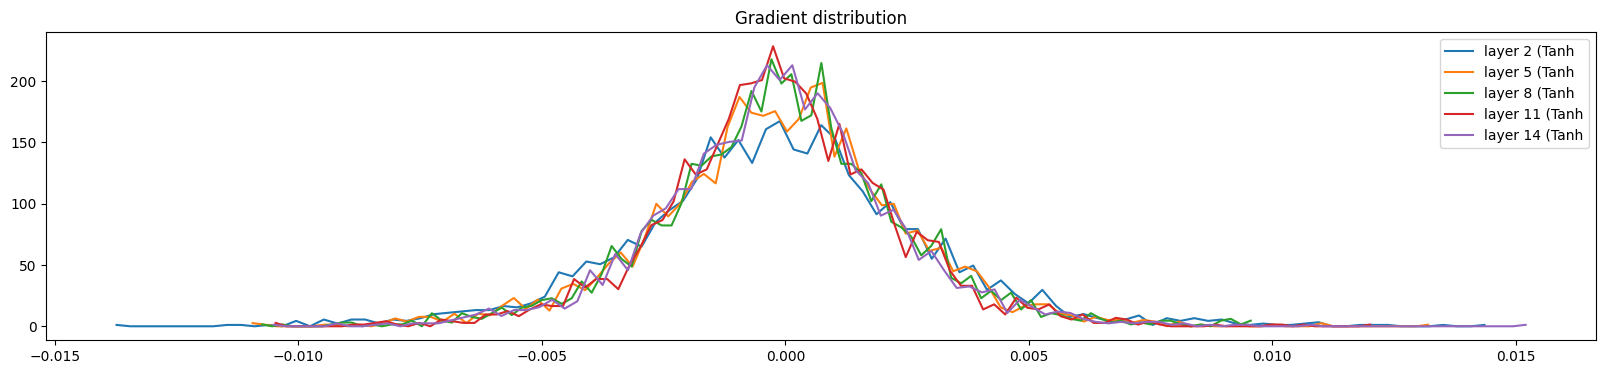

In [95]:
# Lets see if the gradients are nicely distributed 
# Visualize histogram to see if the values from tanh are distributed equally between all values b/w -1 & 1
plt.figure(figsize = (20,4)) # width and height of the plot
legends = []
for i , layer in enumerate(layers[:-1]): # note excluse the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('Gradient distribution')

Weight   (27, 10) | mean -0.000000 | std 8.532065e-03 | grad:data ratio 8.523461e-03
Weight  (30, 100) | mean +0.000056 | std 6.926514e-03 | grad:data ratio 2.216306e-02
Weight (100, 100) | mean +0.000067 | std 5.648528e-03 | grad:data ratio 3.379712e-02
Weight (100, 100) | mean -0.000042 | std 5.028826e-03 | grad:data ratio 2.982526e-02
Weight (100, 100) | mean -0.000000 | std 4.746156e-03 | grad:data ratio 2.828118e-02
Weight (100, 100) | mean -0.000004 | std 4.276121e-03 | grad:data ratio 2.547080e-02
Weight  (100, 27) | mean +0.000019 | std 7.934636e-03 | grad:data ratio 4.761428e-02


Text(0.5, 1.0, 'Weights Gradient distribution')

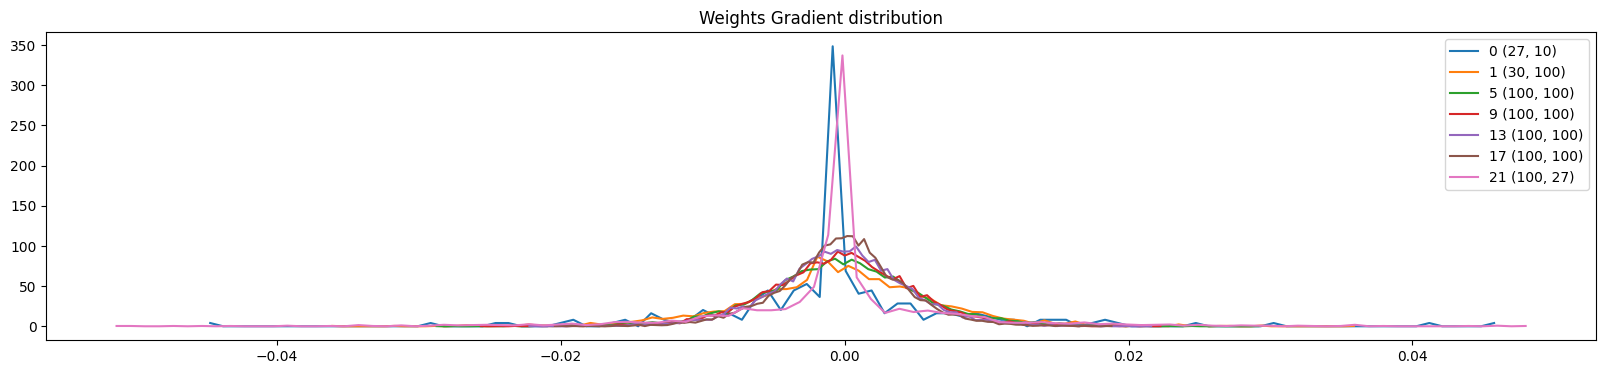

In [96]:
# visualize the weights distribution
plt.figure(figsize = (20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('Weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(),t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weights Gradient distribution')        


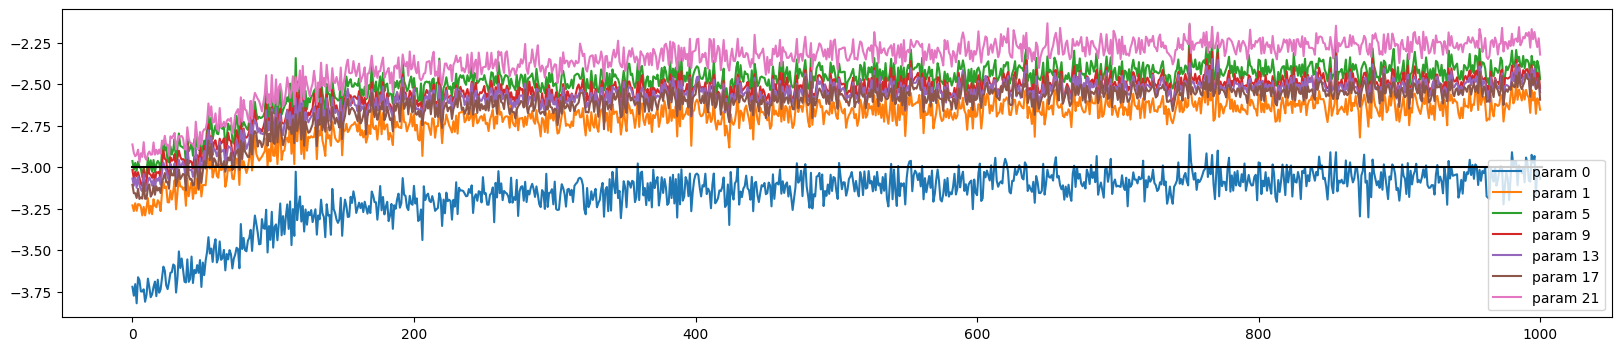

In [97]:
plt.figure(figsize = (20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: # we are looking the updates on weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
        

In [98]:
# final Code together

In [99]:
# Initializations

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # number of neuroons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size , n_embd) ,             generator = g)
W1 = torch.randn((n_embd * block_size , n_hidden) , generator = g) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,                          generator = g) * 0.01 # just to show little bit variation 
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.01 # its always safer to keep the weights closer to 0 than initializing them to 0
b2 = torch.randn(vocab_size,                        generator = g) * 0

bngain = torch.ones((1, n_hidden)) # batch normalization initial gain
bnbias = torch.zeros((1, n_hidden)) # batch normalization initial bias
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# bngain and bnbias will allow neural network to learn through backpropogation and then shift values to maintain the standarddeviation to 1

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set the require_gradient values to True
for p in parameters: 
    p.requires_grad = True

12097


In [100]:
# neural network setup

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out) , generator = g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x@ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters ( trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers ( trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True) # batch mean
            xvar = x.var(0, keepdim = True, unbiased = True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize the unit variance
        self.out = self.gamma * xhat + self.beta
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 # the dimensionality of the charcater embedded vectors
n_hidden = 100 # the number of neurons in the hidden layer of MLP
g =  torch.Generator().manual_seed(2147483647) # for reproducability

# we are using 6 layer MLP
C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd*block_size , n_hidden , bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden , n_hidden , bias = False), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden , bias = False), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden , bias = False), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden, bias = False), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , vocab_size , bias = False), BatchNorm1d(vocab_size),
    
]

with torch.no_grad():
    #last layer : make less confident
   # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [101]:
# its always important to get the ratio by which the weights are being updated . To keep track of this we add new parameter ud

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini_batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb , Yb = Xtr[ix] , Ytr[ix] # batch X, Y

    #forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0] , -1) # concatinate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss functions

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # after debug : would take out retrain_grad
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0 : # print every once in a while
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    lossi.append(loss.log10().item())


      0/ 200000 : 3.3136
  10000/ 200000 : 2.3016
  20000/ 200000 : 2.3208
  30000/ 200000 : 2.2121
  40000/ 200000 : 2.2476
  50000/ 200000 : 2.0265
  60000/ 200000 : 2.1557
  70000/ 200000 : 2.2830
  80000/ 200000 : 1.8788
  90000/ 200000 : 1.8509
 100000/ 200000 : 2.0255
 110000/ 200000 : 2.2019
 120000/ 200000 : 2.4034
 130000/ 200000 : 1.9753
 140000/ 200000 : 2.0841
 150000/ 200000 : 2.1819
 160000/ 200000 : 1.9326
 170000/ 200000 : 2.0584
 180000/ 200000 : 2.0791
 190000/ 200000 : 1.8565


layer 2 (      Tanh): mean +0.01, std 0.67, saturated: 13.62%
layer 5 (      Tanh): mean +0.01, std 0.72, saturated: 16.06%
layer 8 (      Tanh): mean +0.00, std 0.74, saturated: 15.91%
layer 11 (      Tanh): mean -0.01, std 0.77, saturated: 16.34%
layer 14 (      Tanh): mean -0.03, std 0.79, saturated: 18.16%


Text(0.5, 1.0, 'activation distribution')

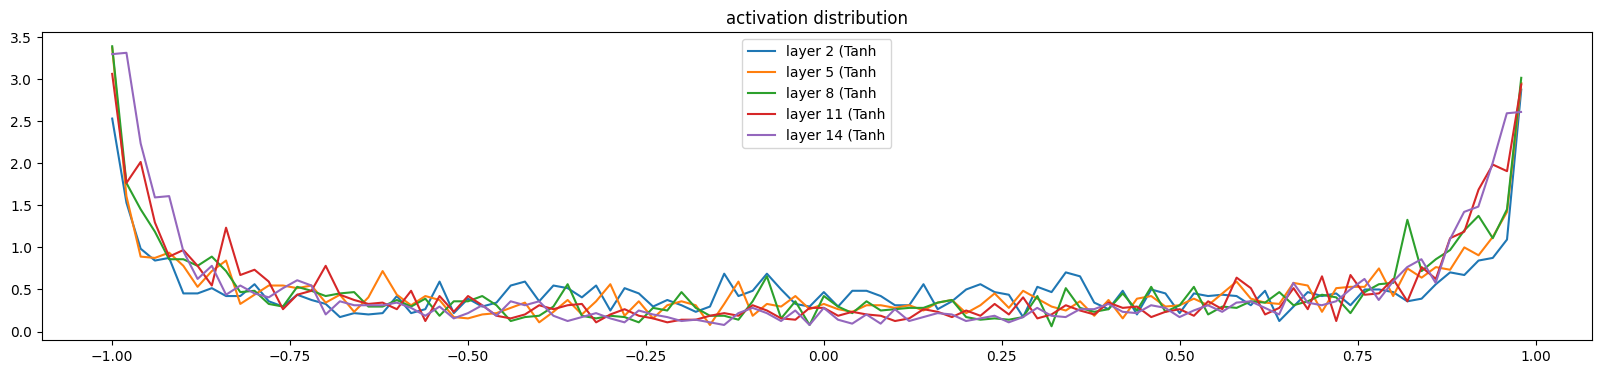

In [102]:
# Visualize histogram to see if the values from tanh are distributed equally between all values b/w -1 & 1
plt.figure(figsize = (20,4)) # width and height of the plot
legends = []
for i , layer in enumerate(layers[:-1]): # note excluse the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'Gradient distribution')

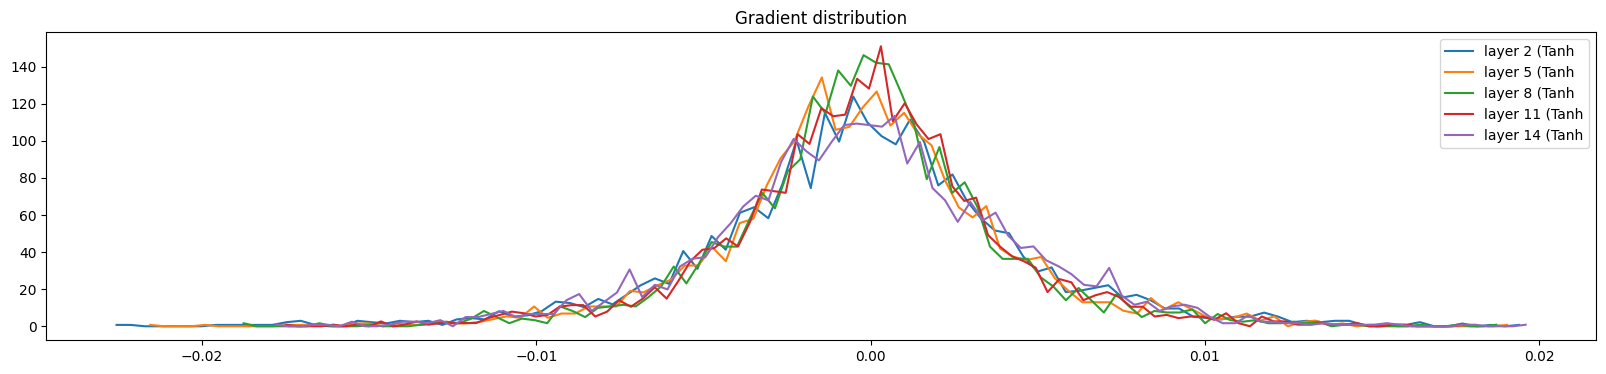

In [103]:
# Lets see if the gradients are nicely distributed 
# Visualize histogram to see if the values from tanh are distributed equally between all values b/w -1 & 1
plt.figure(figsize = (20,4)) # width and height of the plot
legends = []
for i , layer in enumerate(layers[:-1]): # note excluse the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('Gradient distribution')

Weight   (27, 10) | mean +0.000000 | std 1.758428e-02 | grad:data ratio 1.611607e-02
Weight  (30, 100) | mean -0.000031 | std 1.005978e-02 | grad:data ratio 2.463006e-02
Weight (100, 100) | mean +0.000038 | std 6.275199e-03 | grad:data ratio 2.544572e-02
Weight (100, 100) | mean -0.000006 | std 6.340180e-03 | grad:data ratio 2.614855e-02
Weight (100, 100) | mean +0.000010 | std 6.237188e-03 | grad:data ratio 2.626736e-02
Weight (100, 100) | mean -0.000018 | std 5.860012e-03 | grad:data ratio 2.564241e-02
Weight  (100, 27) | mean +0.000061 | std 1.174039e-02 | grad:data ratio 3.546599e-02


Text(0.5, 1.0, 'Weights Gradient distribution')

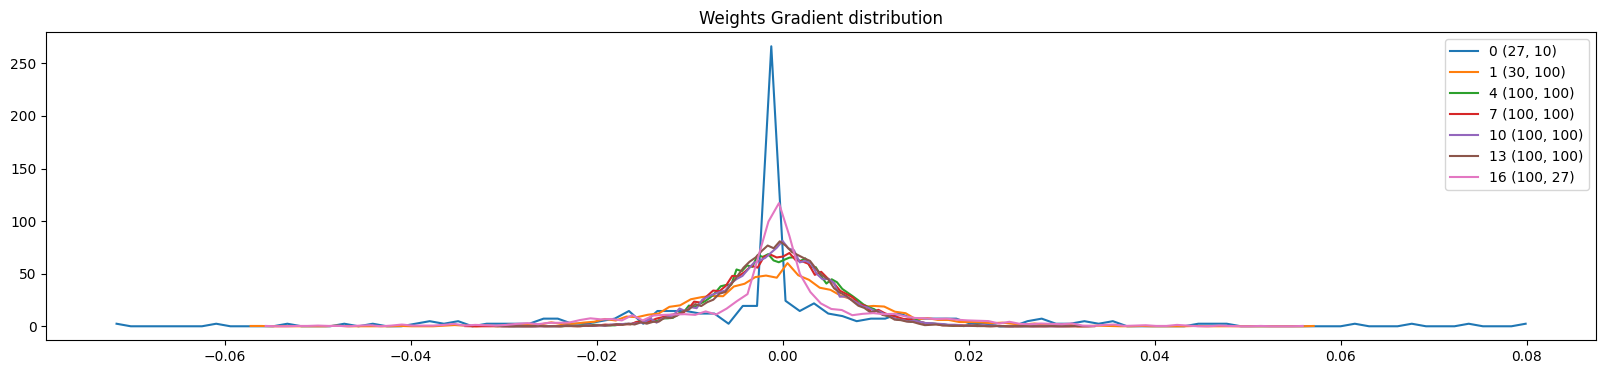

In [104]:
# visualize the weights distribution
plt.figure(figsize = (20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('Weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(),t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weights Gradient distribution')        

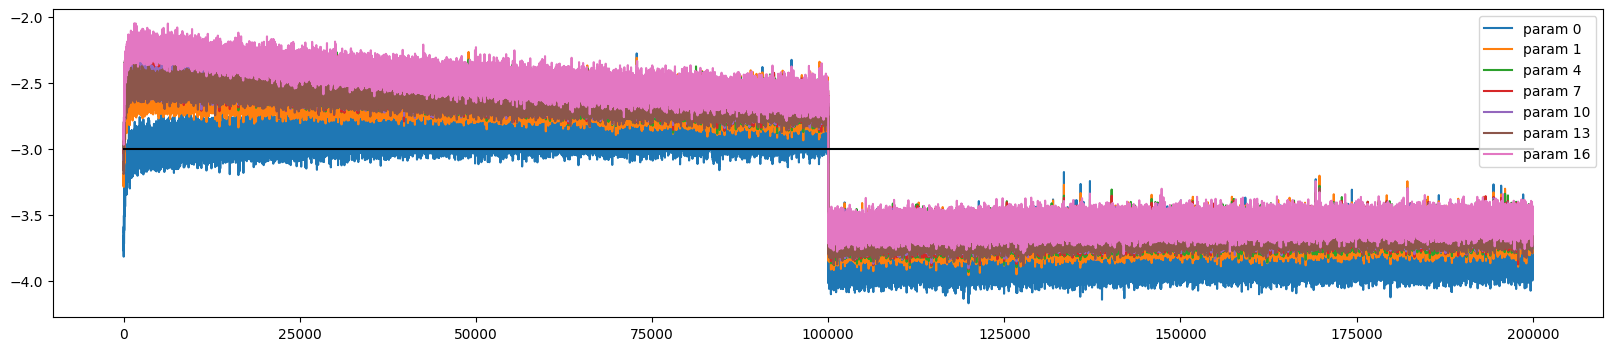

In [105]:
plt.figure(figsize = (20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2: # we are looking the updates on weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' %i)
plt.plot([0, len(ud)], [-3,-3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)